In [1]:
import torch

In [2]:
torch.__version__

'1.12.1+cu113'

In [3]:
!pip -q install rdkit-pypi
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential, GATConv, SAGEConv, GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

In [5]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv

--2022-11-28 02:08:42--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.193.2
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.193.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148743 (145K) [text/csv]
Saving to: ‘BBBP.csv.3’

BBBP.csv.3          100%[===================>] 145.26K   317KB/s    in 0.5s    

2022-11-28 02:08:43 (317 KB/s) - ‘BBBP.csv.3’ saved [148743/148743]



In [6]:
df = pd.read_csv("./BBBP.csv", usecols=[1, 2, 3])
df.head()

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [7]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [8]:
def molecule_from_smiles(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list, Y):
    data_list = []

    for smiles, y in zip(smiles_list, Y):
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)
        atom_features = torch.tensor(atom_features, dtype=torch.float32)
        bond_features = torch.tensor(bond_features, dtype=torch.float32)
        pair_indices = torch.tensor(pair_indices, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        pair_indices = pair_indices.T

        data_list.append(Data(x=atom_features, edge_index=pair_indices, edge_attr=bond_features, y=y, num_nodes=atom_features.shape[0]))

    return data_list


permuted_indices = np.random.permutation(np.arange(df.shape[0]))

train_index = permuted_indices[: int(df.shape[0] * 0.8)]
train_data = graphs_from_smiles(df.iloc[train_index].smiles, df.iloc[train_index].p_np)

valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.9)]
valid_data = graphs_from_smiles(df.iloc[valid_index].smiles, df.iloc[valid_index].p_np)

test_index = permuted_indices[int(df.shape[0] * 0.9) :]
test_data = graphs_from_smiles(df.iloc[test_index].smiles, df.iloc[test_index].p_np)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

Name:	Terbutylchlorambucil
SMILES:	C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
BBBP:	1
Molecule:


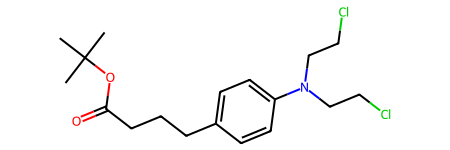

In [9]:
num = 1
print(f"Name:\t{df.name[num]}\nSMILES:\t{df.smiles[num]}\nBBBP:\t{df.p_np[num]}")
molecule = molecule_from_smiles(df.iloc[num].smiles)
print("Molecule:")
molecule

In [10]:
from torch_geometric.graphgym import AtomEncoder
from torch_geometric.nn import global_add_pool, global_mean_pool

class GAT_Model(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(GAT_Model, self).__init__()

        self.node_encoder = Linear(29, hidden_dim)
        
        self.GAT_Convs = torch.nn.ModuleList(
            [GATConv(hidden_dim, hidden_dim, )] +
            [GATConv(hidden_dim, hidden_dim)] +
            [GATConv(hidden_dim, hidden_dim)]
        )

        self.bns = torch.nn.ModuleList(
            [torch.nn.BatchNorm1d(num_features=hidden_dim) for _ in range(3)]
        )

        self.pool = global_mean_pool

        self.linear = Linear(hidden_dim, output_dim)
        self.ReLU = ReLU()
        self.Sigmoid = torch.nn.Sigmoid()

    def forward(self, batched_data):

    
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        x = self.node_encoder(x)

        for i in range(len(self.bns)):
          x = self.GAT_Convs[i](x, edge_index)
          x = self.bns[i](x)
          x = self.ReLU(x)
        x = self.GAT_Convs[-1](x, edge_index)
        pooled = self.pool(x, batch)
        out = self.linear(pooled)
        out = self.Sigmoid(out)

        return out

/usr/local/lib/python3.7/dist-packages/torch_geometric/graphgym/config.py:19: UserWarning: Could not define global config object. Please install 'yacs' for using the GraphGym experiment manager via 'pip install yacs'.
  warnings.warn("Could not define global config object. Please install "
/usr/local/lib/python3.7/dist-packages/torch_geometric/graphgym/imports.py:14: UserWarning: Please install 'pytorch_lightning' for using the GraphGym experiment manager via 'pip install pytorch_lightning'
  warnings.warn("Please install 'pytorch_lightning' for using the GraphGym "
/usr/local/lib/python3.7/dist-packages/torch_geometric/graphgym/logger.py:23: UserWarning: Please install 'pytorch_lightning' for using the GraphGym experiment manager via 'pip install pytorch_lightning'
  warnings.warn("Please install 'pytorch_lightning' for using the GraphGym "


In [11]:
model = GAT_Model(30, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [12]:
import copy

epochs = 200
best_valid_acc = 0
best_model = copy.deepcopy(model)
for epoch in range(1, epochs+1):
  pred_y = []
  true_y = []
  valid_pred_y = []
  valid_true_y = []

  loss_sum = 0
  for batch in train_loader:
    out = model(batch)
    optimizer.zero_grad()
    loss = loss_fn(out.view(-1), batch.y.float())
    loss.backward()
    optimizer.step()
    pred_y.extend(out.view(-1).detach().numpy())
    true_y.extend(batch.y.float().numpy())
    loss_sum += loss.item()
  for batch in valid_loader:
    out = model(batch)
    valid_pred_y.extend(out.view(-1).detach().numpy())
    valid_true_y.extend(batch.y.float().numpy())
  
  if f1_score(valid_true_y, np.round(valid_pred_y)) > best_valid_acc:
    best_valid_acc = f1_score(valid_true_y, np.round(valid_pred_y))
    best_model = copy.deepcopy(model)

  if epoch % 10 == 0:
    print(f"[Epoch: {epoch:3d}/{epochs}] [Loss: {loss_sum:.6f}] [F1 score on train dataset: {f1_score(true_y, np.round(pred_y)):6f}] [F1 score on valid dataset: {f1_score(valid_true_y, np.round(valid_pred_y)):6f}]" )

[Epoch:  10/200] [Loss: 25.233879] [F1 score on train dataset: 0.912726] [F1 score on valid dataset: 0.913433]
[Epoch:  20/200] [Loss: 24.580544] [F1 score on train dataset: 0.922718] [F1 score on valid dataset: 0.905775]
[Epoch:  30/200] [Loss: 24.392262] [F1 score on train dataset: 0.927188] [F1 score on valid dataset: 0.908012]
[Epoch:  40/200] [Loss: 24.182164] [F1 score on train dataset: 0.933333] [F1 score on valid dataset: 0.907463]
[Epoch:  50/200] [Loss: 23.891335] [F1 score on train dataset: 0.937427] [F1 score on valid dataset: 0.894260]
[Epoch:  60/200] [Loss: 23.919633] [F1 score on train dataset: 0.935409] [F1 score on valid dataset: 0.898810]
[Epoch:  70/200] [Loss: 23.864015] [F1 score on train dataset: 0.934324] [F1 score on valid dataset: 0.907463]
[Epoch:  80/200] [Loss: 23.728965] [F1 score on train dataset: 0.939759] [F1 score on valid dataset: 0.900901]
[Epoch:  90/200] [Loss: 23.845014] [F1 score on train dataset: 0.938474] [F1 score on valid dataset: 0.899083]
[

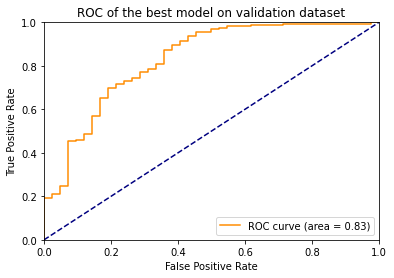

In [13]:
valid_pred_y = []
valid_true_y = []

for batch in valid_loader:
  out = best_model(batch)
  valid_pred_y.extend(out.view(-1).detach().numpy())
  valid_true_y.extend(batch.y.float().numpy())

fpr, tpr, threshould = roc_curve(valid_true_y, valid_pred_y)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr)
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of the best model on validation dataset")
plt.legend(loc="lower right")
plt.show()

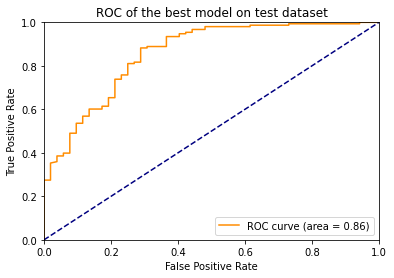

In [14]:
test_pred_y = []
test_true_y = []

for batch in test_loader:
  out = best_model(batch)
  test_pred_y.extend(out.view(-1).detach().numpy())
  test_true_y.extend(batch.y.float().numpy())

fpr, tpr, threshould = roc_curve(test_true_y, test_pred_y)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr)
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of the best model on test dataset")
plt.legend(loc="lower right")
plt.show()